# Julia 深度學習：類神經網路模型簡介

## 作業 032：訓練 MLP 學習門牌號碼資料集

訓練一個 MLP 模型來學習門牌號碼資料集。

注意：MLP 模型的能力有限，可能會導致訓練起來效果不佳。

注意：近期 Flux 正在持續更新，請確保您的 Julia 在 v1.3 版以上，以及 Flux 在 v0.10.4 以上或是最新版。

In [1]:
using Flux
using Flux.Data: DataLoader
using Flux: @epochs, onecold, onehotbatch, throttle, logitcrossentropy
using MLDatasets
using Statistics

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1260


In [2]:
using Plots
using Images

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260


## 讀取資料

呼叫 SVHN2 資料集的過程中，會先去檢查以前是否有下載過，如果是第一次下載，過程中會詢問是否下載資料集，請回答 `y`。整個資料集的大小約為 1.6 GB，下載時間可能會稍久，請耐心等候。

In [3]:
train_X, train_y = SVHN2.traindata(Float32)
test_X,  test_y  = SVHN2.testdata(Float32)

(Float32[0.14901961 0.15294118 … 0.19607843 0.1882353; 0.15294118 0.15294118 … 0.2 0.1882353; … ; 0.16470589 0.16862746 … 0.1764706 0.17254902; 0.15294118 0.15294118 … 0.16470589 0.16470589]

Float32[0.40392157 0.40784314 … 0.45882353 0.4509804; 0.40784314 0.40784314 … 0.4627451 0.4509804; … ; 0.40392157 0.39607844 … 0.45490196 0.4509804; 0.38039216 0.38039216 … 0.44313726 0.44313726]

Float32[0.23529412 0.23921569 … 0.29803923 0.2901961; 0.23921569 0.23921569 … 0.3019608 0.2901961; … ; 0.24313726 0.24705882 … 0.28235295 0.2784314; 0.22352941 0.22352941 … 0.27058825 0.2784314]

Float32[0.5058824 0.5254902 … 0.5411765 0.5137255; 0.49803922 0.52156866 … 0.50980395 0.47843137; … ; 0.48235294 0.49411765 … 0.39607844 0.43529412; 0.48235294 0.49019608 … 0.4392157 0.48235294]

Float32[0.5568628 0.5882353 … 0.59607846 0.5686275; 0.56078434 0.58431375 … 0.5647059 0.53333336; … ; 0.5254902 0.5372549 … 0.41960785 0.4627451; 0.5294118 0.5372549 … 0.4627451 0.50980395]

Float32[0.6 0.627451 … 0.647

In [4]:
println(size(train_X))
println(size(train_y))
println(size(test_X))
println(size(test_y))

(32, 32, 3, 73257)
(73257,)
(32, 32, 3, 26032)
(26032,)


In [5]:
println(typeof(train_X))
println(typeof(train_y))
println(typeof(test_X))
println(typeof(test_y))

Array{Float32,4}
Array{Int64,1}
Array{Float32,4}
Array{Int64,1}


## Show 10 training examples

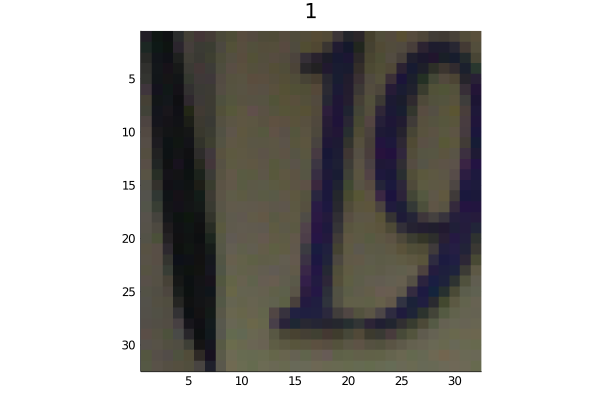

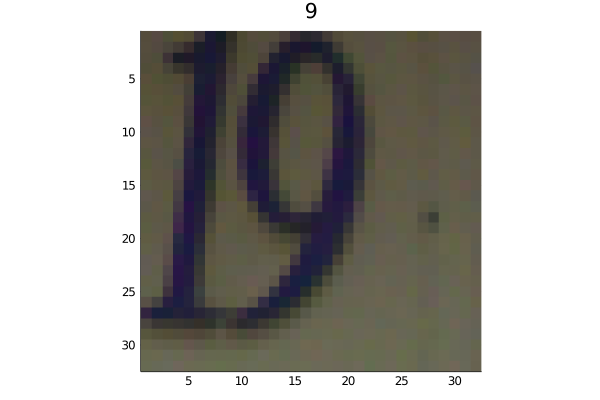

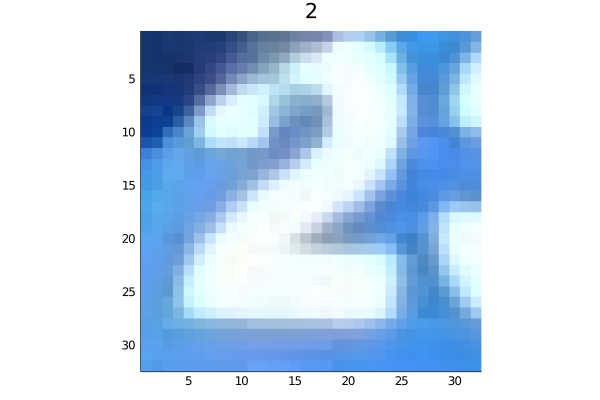

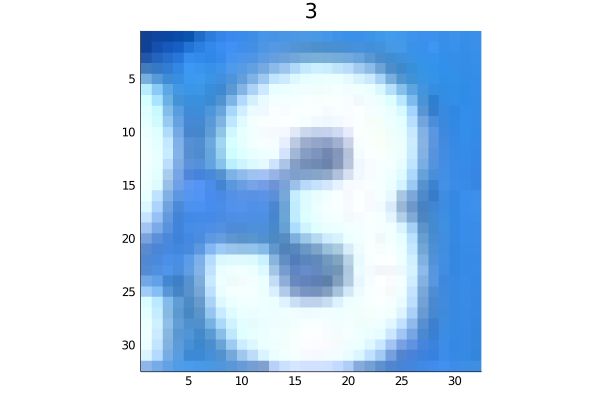

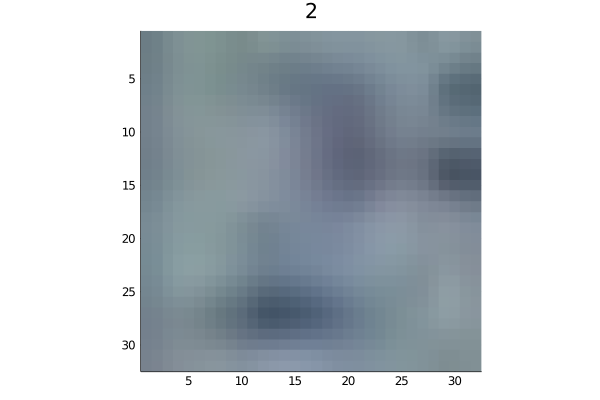

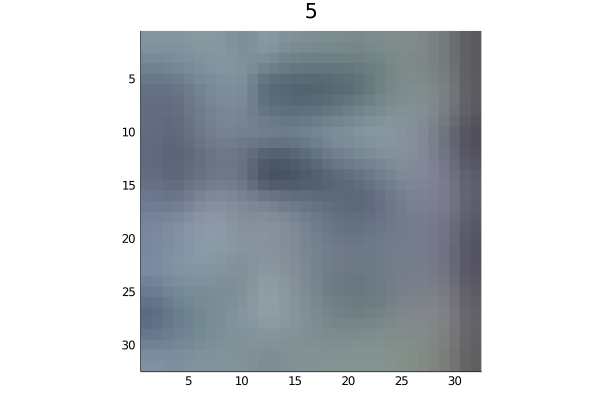

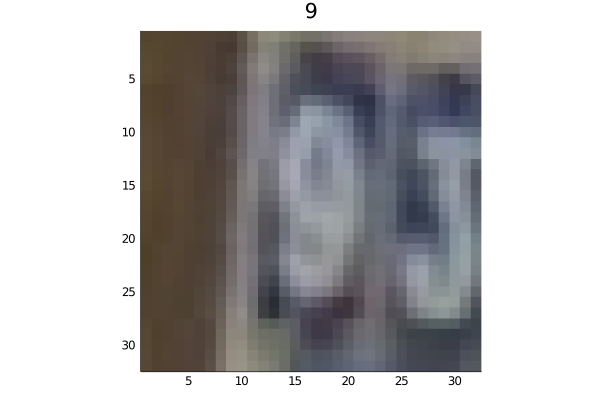

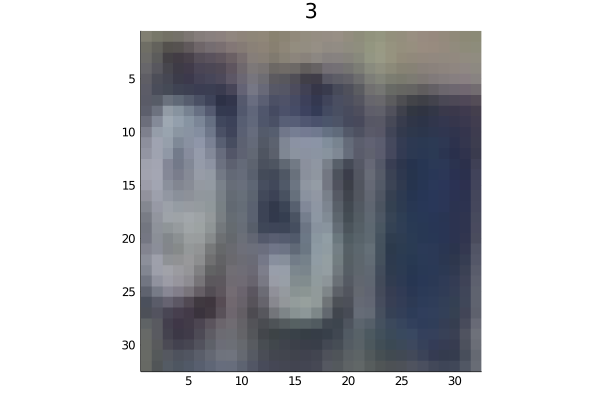

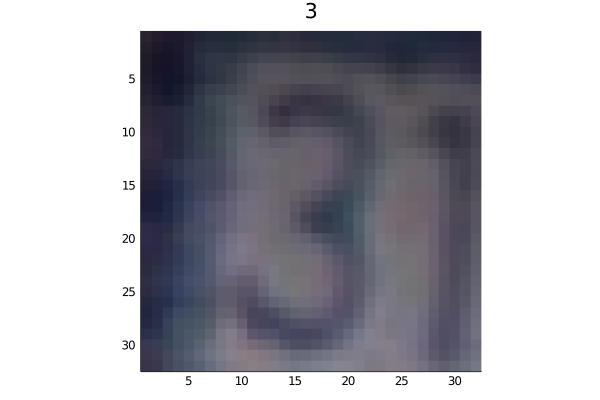

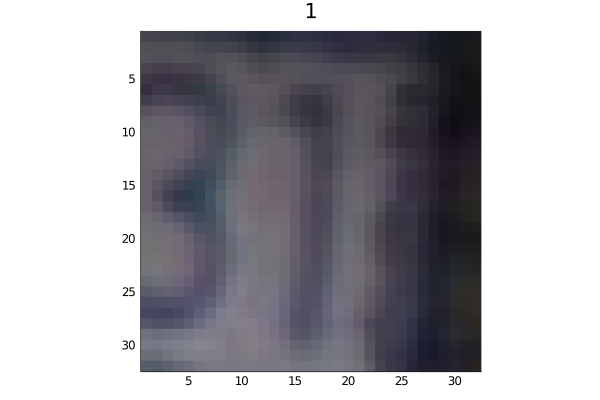

In [6]:
# https://stackoverflow.com/questions/24846267/how-to-switch-axes-dimensions-in-julia-for-n-dimensional-array
# https://discourse.julialang.org/t/plotting-in-a-loop/10074/2
# https://medium.com/@alienrobot/part-1-julia-images-moving-from-python-to-julia-image-i-o-basic-manipulations-eecae73fe04d
for i in 1:10
#     IJulia.clear_output(true)
    img_x = colorview(RGB, permutedims(train_X[:, :, : ,i], [3, 2, 1]));
    p = plot(img_x);
    title!(string(train_y[i]));
    Plots.display(p);
#     sleep(0.1)
end

In [8]:
train_X = Flux.flatten(train_X)
test_X = Flux.flatten(test_X)
train_y = onehotbatch(train_y, 1:10)
test_y = onehotbatch(test_y, 1:10)

10×26032 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  1  0  0  1  0  1  1  0  0  0  0  …  1  0  1  0  1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  1  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  0  0  0  0  0

In [9]:
println(size(train_X))
println(size(train_y))
println(size(test_X))
println(size(test_y))

(3072, 73257)
(10, 73257)
(3072, 26032)
(10, 26032)


In [10]:
println(typeof(train_X))
println(typeof(train_y))
println(typeof(test_X))
println(typeof(test_y))

Array{Float32,2}
Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}
Array{Float32,2}
Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}


## hyper parameters

In [81]:
epochs = 20
batchsize = 512
learining_rate = 0.002
decay = 0.1
decay_step = 1
clip = 1e-4
optimizer = Flux.Optimiser(ExpDecay(learining_rate, decay, decay_step, clip), ADAM(learining_rate))

Flux.Optimise.Optimiser(Any[ExpDecay(0.002, 0.1, 1, 0.0001, IdDict{Any,Any}()), ADAM(0.002, (0.9, 0.999), IdDict{Any,Any}())])

## data loader

In [82]:
train = DataLoader(train_X, train_y, batchsize=batchsize, shuffle=true)
test = DataLoader(test_X, test_y, batchsize=batchsize)

DataLoader((Float32[0.14901961 0.5058824 … 0.3764706 0.39607844; 0.15294118 0.49803922 … 0.38039216 0.39215687; … ; 0.2784314 0.5647059 … 0.2901961 0.19607843; 0.2784314 0.6117647 … 0.26666668 0.19607843], Bool[0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 512, 26032, true, 26032, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  26023, 26024, 26025, 26026, 26027, 26028, 26029, 26030, 26031, 26032], false)

## loss function

In [83]:
loss(x, y) = logitcrossentropy(model(x), y)

loss (generic function with 1 method)

## callback function

In [84]:
function test_loss()
    l = 0f0
    for (x, y) in test
        l += loss(x, y)
    end
    l/length(test)
end

evalcb() = @show(test_loss())

evalcb (generic function with 1 method)

## evaluation function

In [77]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

## NN model

In [85]:
model = Chain(
    Dense(size(train_X, 1), 512, relu),
    Dense(512, 256, relu),
    Dense(256, 128, relu),
    Dense(128, size(train_y, 1)),
    logsoftmax
)

Chain(Dense(3072, 512, relu), Dense(512, 256, relu), Dense(256, 128, relu), Dense(128, 10), logsoftmax)

## training model

In [86]:
@epochs epochs Flux.train!(loss, params(model), train, optimizer, cb=throttle(evalcb, 10))

┌ Info: Epoch 1
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 5.929716f0


┌ Info: Epoch 2
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2427523f0


┌ Info: Epoch 3
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.086965f0


┌ Info: Epoch 4
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 1.6491327f0
test_loss() = 1.3467032f0


┌ Info: Epoch 5
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121
┌ Info: Epoch 6
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 1.2777767f0
test_loss() = 1.1823264f0


┌ Info: Epoch 7
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 1.1200058f0


┌ Info: Epoch 8
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 1.0925511f0
test_loss() = 1.2064744f0

┌ Info: Epoch 9
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121



test_loss() = 1.0448165f0

┌ Info: Epoch 10
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


┌ Info: Epoch 11
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.96174395f0
test_loss() = 0.9221745f0
test_loss() = 1.0642091f0

┌ Info: Epoch 12
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


┌ Info: Epoch 13
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.9353983f0
test_loss() = 0.88239664f0
test_loss() = 0.87612534f0


┌ Info: Epoch 14
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.90346223f0


┌ Info: Epoch 15
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121
┌ Info: Epoch 16
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.8887205f0
test_loss() = 0.90890557f0


┌ Info: Epoch 17
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121
┌ Info: Epoch 18
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.86229646f0


┌ Info: Epoch 19
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.84955865f0


┌ Info: Epoch 20
└ @ Main C:\Users\kai\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 0.97330093f0


## model evaluation

In [87]:
using Printf
@printf("Accuracy: %.2f%%\n", accuracy(test_X, test_y)*100)

Accuracy: 75.31%
